<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Optimization-params" data-toc-modified-id="Optimization-params-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Optimization params</a></span></li><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Benchmark</a></span></li><li><span><a href="#Time-Forest" data-toc-modified-id="Time-Forest-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Time Forest</a></span></li><li><span><a href="#Simplified-benchmark" data-toc-modified-id="Simplified-benchmark-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simplified benchmark</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plots</a></span></li></ul></div>

# GE News - Time Forest Vs Random Forest

In [69]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pdb
import warnings
import seaborn as sns

from sklearn import metrics
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from time_robust_forest.hyper_opt import env_wise_hyper_opt
from aux_functions import *

warnings.filterwarnings('ignore')

In [70]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [71]:
set_style()

In [72]:
STOP_WORDS = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']
CLUB_WORDS = ["verdão", "tricolor", "fla", "timão", "rubro", 
              "negro", "flamengo", "paulo", "palmeirense", "paulista", 
              "inter", "colorado", "internacional", "colorados", "colorada"]
STOP_WORDS += CLUB_WORDS
MAX_VOCABULARY = 300
positive_case = "flamengo"

In [73]:
data = pd.read_csv("~/Documents/datasets/ge_news/data/ge_news.csv", index_col=False)

In [74]:
data.shape

(155357, 6)

In [75]:
data = data.sample(frac=0.2)

In [76]:
def create_different_time_slices(data, time_col="date", aggregation="weekly", n_months=None):
    if aggregation == "daily": return data[time_col].dt.date
    if aggregation == "weekly": return data[time_col].dt.week
    if aggregation == "monthly": return data[time_col].apply(lambda x: x.strftime("%Y-%m"))
    if aggregation == "semester": return False


def exclude_periods_without_positive_case(data, positive_case, period_column, threshold=20):
    df = data.groupby(period_column)["club"].apply(lambda x: np.sum(x == positive_case))
    df = df[df > threshold]
    return data[data[period_column].isin(df.index)]
    
def clean_club_name_from_article(data):
    data["text"] = data.apply(lambda x: x["text"].lower().replace(x["club"].replace("-", " "), ""), axis=1)
    return data

def exclude_numbers(data):
    data["text"] = data["text"].apply(lambda x: ''.join([i for i in x.lower() if not i.isdigit()]))
    return data

def drop_multiple_teams_news(data):
    multiple_team_news = data.groupby("link", as_index=False)["club"].count()
    multiple_team_news = multiple_team_news[multiple_team_news["club"] > 1]["link"]
    return data[~data["link"].isin(multiple_team_news)]


In [77]:
data = clean_club_name_from_article(data)
data = exclude_numbers(data)
data = drop_multiple_teams_news(data)

In [78]:
data.loc[:, "year"] = data["date"].apply(lambda x: x.split("/")[-1])
data.loc[:, "month"] = data["date"].apply(lambda x: x.split("/")[1])
data.loc[:, "date"] = pd.to_datetime(data["date"])

In [79]:
### Monthly context
data["year-month"] = data["year"] + "-" + data["month"]

### Weekly context
data["year-week"] = create_different_time_slices(data)
data["year-week"] = data["year"] + "-" + data["year-week"].astype(str)

In [80]:
data["target"] = data["club"].apply(lambda x: 1 if x == positive_case else 0)

print("The fraction of positive cases is {:.2f}".format(data["target"].mean()))

The fraction of positive cases is 0.09


In [81]:
data = exclude_periods_without_positive_case(data, positive_case, "year-month")

In [82]:
train_end_date = "2019-01"
holdout_end_date = "2021-12"
train_end_year = int(train_end_date.split("-")[0])

In [83]:
in_time = data[data["year-month"] < train_end_date]

train, test = train_test_split(in_time, 
                               test_size=0.2, 
                               random_state=42)

out_of_time = data[(data["year-month"] >= train_end_date) & (data["year-month"] <= holdout_end_date)]

In [84]:
target = "target"
time_column = "year-month"
time_column = "year"
dummy_time_column = "dummy_date"

In [85]:
print("Dataset shapes:")
print("Train: {}".format(train.shape))
print("Test: {}".format(test.shape))
print("Out of time: {}".format(out_of_time.shape))

Dataset shapes:
Train: (6557, 11)
Test: (1640, 11)
Out of time: (16924, 11)


In [86]:
vectorizer = TfidfVectorizer(max_features=MAX_VOCABULARY,
                             stop_words=STOP_WORDS,
                             binary=False,
                             use_idf=True,
                             norm=False)

train_vectors = pd.DataFrame(vectorizer.fit_transform(train["text"]).toarray(), columns=vectorizer.vocabulary_)
test_vectors = pd.DataFrame(vectorizer.transform(test["text"]).toarray(), columns=vectorizer.vocabulary_)
oot_vectors = pd.DataFrame(vectorizer.transform(out_of_time["text"]).toarray(), columns=vectorizer.vocabulary_)

In [87]:
features = list(vectorizer.vocabulary_.keys())

In [88]:
train_vectors[time_column] = train[time_column].values
test_vectors[time_column] = test[time_column].values
oot_vectors[time_column] = out_of_time[time_column].values

In [89]:
train_vectors[dummy_time_column] = 1

In [90]:
model = RandomForestClassifier(max_depth=10, n_estimators=25)

In [91]:
model.fit(train_vectors.drop(columns=[time_column, dummy_time_column]), train["target"].values)

RandomForestClassifier(max_depth=10, n_estimators=25)

In [92]:
train["prediction"] = model.predict_proba(train_vectors.drop(columns=[time_column, dummy_time_column]))[:, 1]
roc_auc_score(train[target], train["prediction"])

0.9531888496000839

In [93]:
test["prediction"] = model.predict_proba(test_vectors.drop(columns=[time_column]))[:, 1]
roc_auc_score(test[target], test["prediction"])

0.8383426378350236

In [94]:
out_of_time["prediction"] = model.predict_proba(oot_vectors.drop(columns=[time_column]))[:, 1]
roc_auc_score(out_of_time[target], out_of_time["prediction"])

0.7805220632605826

## Optimization params

In [124]:
# params_grid = {"n_estimators": [30], 
#               "max_depth": [5, 10, 15],
#               "min_impurity_decrease": [1e-3, 0],
#               "min_sample_periods": [1, 5, 10],
#               "period_criterion": ["max", "avg"]}

params_grid = {"n_estimators": [4], 
              "max_depth": [10],
              "min_impurity_decrease": [0, 0.0001],
              "min_sample_periods": [1, 2],
              "period_criterion": ["max"]}

params_grid_benchmark = params_grid.copy()
params_grid_benchmark.pop("period_criterion")

['max']

## Benchmark

In [125]:
model = TimeForestClassifier(time_column=dummy_time_column,
                                        multi=True)

benchmark_opt_param = env_wise_hyper_opt(train_vectors[features + [dummy_time_column]], train[target], 
                                         model, 
                                         dummy_time_column, 
                                         params_grid_benchmark, 
                                         cv=5,
                                         score=roc_auc_score)

benchmark_model = TimeForestClassifier(time_column=dummy_time_column,
                                       multi=True, 
                                       **benchmark_opt_param)

benchmark_model.fit(train_vectors[features + [dummy_time_column]], train[target])

In [126]:
benchmark_opt_param

{'max_depth': 10,
 'min_impurity_decrease': 0.0001,
 'min_sample_periods': 2,
 'n_estimators': 4}

In [127]:
importance = benchmark_model.feature_importance(impurity_decrease=True)
importance.rename(columns={"Importance": "Random Forest"}, inplace=True)
importance.head(20)

,Random Forest
Feature,
ainda,0.022244
sequência,0.018794
goleiro,0.006499
adversário,0.006143
esporte,0.005843
profissional,0.005310
todo,0.004908
possível,0.003779
marcelo,0.003717


In [128]:
train["benchmark_prediction"] = benchmark_model.predict_proba(train_vectors[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test_vectors[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(oot_vectors[features])[:, 1]

## Time Forest

In [129]:
model = TimeForestClassifier(time_column=time_column,
                                        multi=True)

challenger_opt_param = env_wise_hyper_opt(train_vectors[features + [time_column]], train[target], 
                                         model, 
                                         time_column, 
                                         params_grid, 
                                         cv=5,
                                         score=roc_auc_score)

challenger_model = TimeForestClassifier(time_column=time_column,
                                       multi=True, 
                                       **challenger_opt_param)

challenger_model.fit(train_vectors[features + [time_column]], train[target])

In [130]:
challenger_opt_param

{'max_depth': 10,
 'min_impurity_decrease': 0.0001,
 'min_sample_periods': 1,
 'n_estimators': 4,
 'period_criterion': 'max'}

In [131]:
challenger_model.feature_importance(impurity_decrease=True).head(20)

,Importance
Feature,
ainda,0.020585
goleiro,0.001782
sequência,0.001388
silva,0.001248
confiança,0.000933
paranaense,0.000761
disso,0.000723
temporada,0.000722
início,0.000639


In [132]:
importance.merge(challenger_model.feature_importance(impurity_decrease=True), left_index=True, right_index=True)

,Random Forest,Importance
Feature,,
ainda,0.022244,0.020585
sequência,0.018794,0.001388
goleiro,0.006499,0.001782
esporte,0.005843,0.000321
profissional,0.005310,0.000248
...,...,...
história,0.000314,0.000184
último,0.000225,0.000311
gabriel,0.000215,0.000132


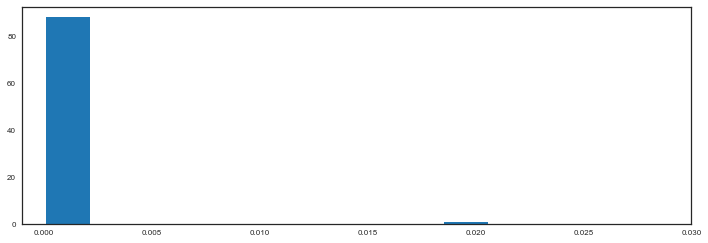

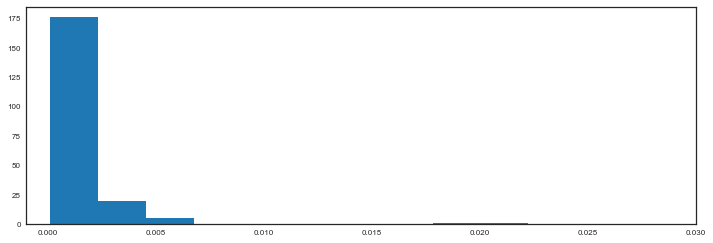

In [133]:
plt.hist(challenger_model.feature_importance(impurity_decrease=True)["Importance"])
plt.xlim([-0.001, 0.03])
plt.show()
plt.hist(benchmark_model.feature_importance(impurity_decrease=True)["Importance"])
plt.xlim([-0.001, 0.03])
plt.show()

In [134]:
train["challenger_prediction"] = challenger_model.predict_proba(train_vectors[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test_vectors[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(oot_vectors[features])[:, 1]

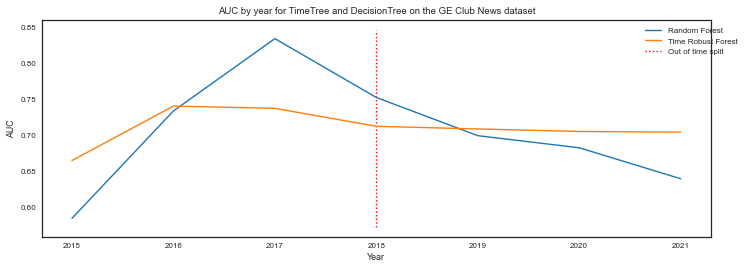

In [135]:
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest")
# pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")
plt.legend(bbox_to_anchor=(1.05, 1.0))

plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

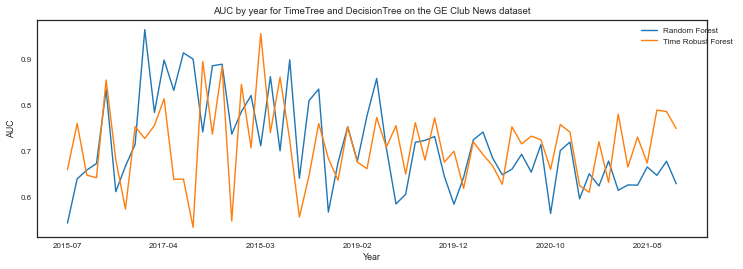

In [136]:
pd.concat([test, out_of_time]).groupby("year-month").apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby("year-month").apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest")
# pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM")

xmin, xmax, ymin, ymax = plt.axis()
#plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")
plt.legend(bbox_to_anchor=(1.05, 1.0))

plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

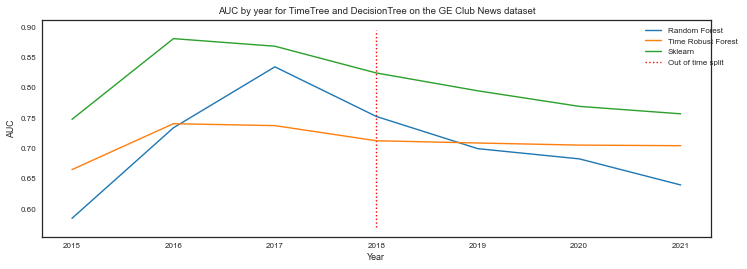

In [137]:
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction"])).plot(label="Sklearn")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")
plt.legend(bbox_to_anchor=(1.05, 1.0))

plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

## Simplified benchmark

Use similar paramters to what the challenger picked in the optimization.

In [138]:
params_simple_benchmark = challenger_opt_param.copy()
params_simple_benchmark.pop("min_sample_periods")

params_simple_benchmark["min_sample_periods"] = train[time_column].nunique() * challenger_opt_param["min_sample_periods"]

simple_benchmark_model = TimeForestClassifier(time_column=dummy_time_column,
                                       multi=True, 
                                       **params_simple_benchmark)

simple_benchmark_model.fit(train_vectors[features + [dummy_time_column]], train[target])

In [139]:
train["benchmark_simple_prediction"] = simple_benchmark_model.predict_proba(train_vectors[features])[:, 1]
test["benchmark_simple_prediction"] = simple_benchmark_model.predict_proba(test_vectors[features])[:, 1]
out_of_time["benchmark_simple_prediction"] = simple_benchmark_model.predict_proba(oot_vectors[features])[:, 1]

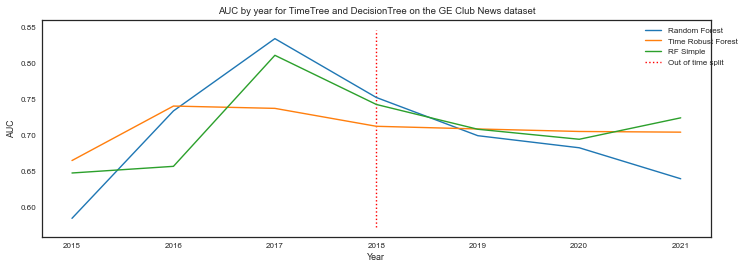

In [140]:
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_simple_prediction"])).plot(label="RF Simple")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")
plt.legend(bbox_to_anchor=(1.05, 1.0))

plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

## Plots

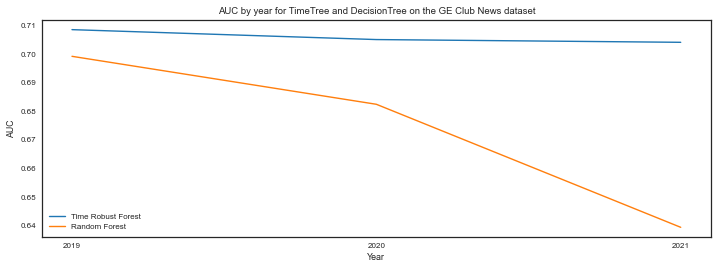

In [141]:
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest")
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest")

plt.legend()
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

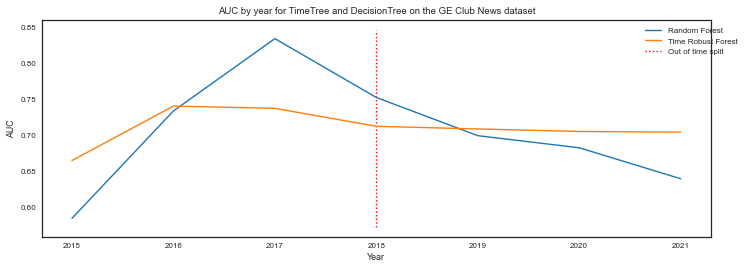

In [142]:
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")
plt.legend(bbox_to_anchor=(1.05, 1.0))

plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

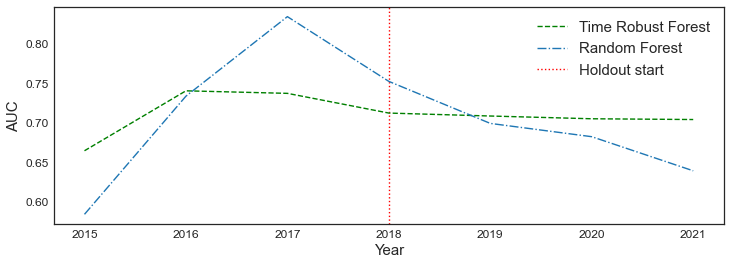

In [145]:
fig, ax = plt.subplots()

pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest",
                                                                                                                        color="green", linestyle="dashed")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest", 
                                                                                                                       linestyle="-.")
# pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM", color="orange")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
#plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))

#plt.legend(bbox_to_anchor=(1.05, 1.0))
#plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")

plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
#plt.savefig("images/ge_sklearn.eps", format="eps", bbox_inches="tight")
plt.savefig("../images/genews_performance_overtime.eps", format="eps")
plt.show()